# Outline

Adjusting the growth of Indices and Stocks by GDP deflation data. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

from scipy.stats import linregress
from scipy.optimize import curve_fit

</br></br></br>

--------------------
# GDP Price Deflation Data

## Load Data:

Sources of GDP deflation data:
 - Source: [FRED Economic Data](https://fred.stlouisfed.org/series/GDPDEF)
 - Description: [GDP Price Deflator](https://www.bea.gov/data/prices-inflation/gdp-price-deflator)

In [2]:
gdpdef_df = pd.read_csv("csv_files/GDPDEF.csv")
gdpdef_df = gdpdef_df.rename(columns={"DATE": "Date"})

print(len(gdpdef_df.index))
display(gdpdef_df.tail(5))

311


,Date,GDPDEF
306,2023-07-01,122.768
307,2023-10-01,123.241
308,2024-01-01,124.163
309,2024-04-01,124.943
310,2024-07-01,125.532


In [3]:
gdpdef_df["DATETIME"] = pd.to_datetime(gdpdef_df["Date"], format="%Y-%m-%d")
gdpdef_df["Day"] = (gdpdef_df["DATETIME"] - pd.Timestamp.today()).dt.days

display(gdpdef_df)

,Date,GDPDEF,DATETIME,Day
0,1947-01-01,11.141,1947-01-01,-28481
1,1947-04-01,11.299,1947-04-01,-28391
2,1947-07-01,11.489,1947-07-01,-28300
3,1947-10-01,11.772,1947-10-01,-28208
4,1948-01-01,11.865,1948-01-01,-28116
...,...,...,...,...
306,2023-07-01,122.768,2023-07-01,-541
307,2023-10-01,123.241,2023-10-01,-449
308,2024-01-01,124.163,2024-01-01,-357
309,2024-04-01,124.943,2024-04-01,-266


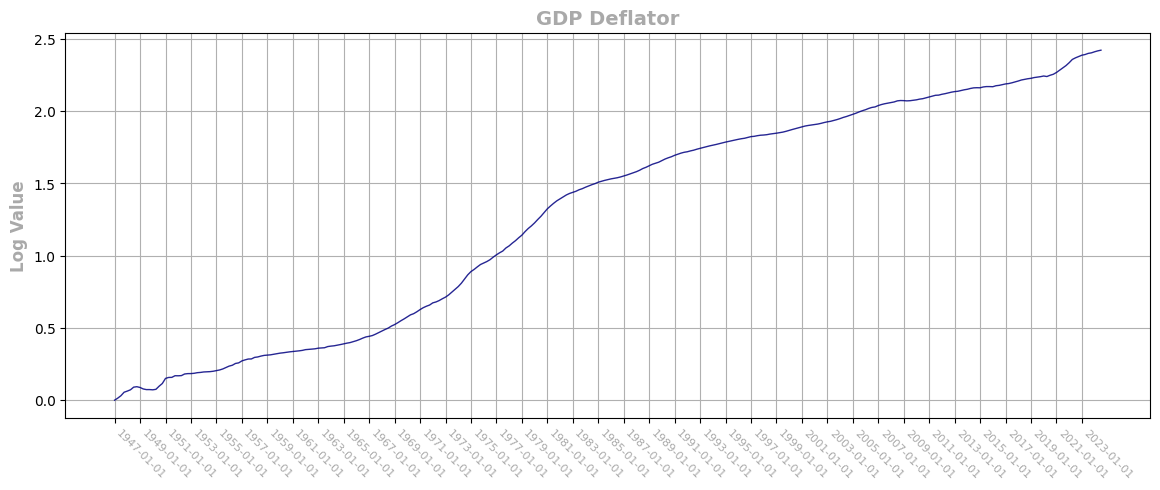

In [4]:
fig = plt.figure(figsize=(14., 5.0))
ax = fig.gca()

day = gdpdef_df["Day"].to_numpy()
gdpdef_val  = gdpdef_df["GDPDEF"].to_numpy()
log_gdpdef_val = np.log(gdpdef_val / gdpdef_val[0])
dates = gdpdef_df["Date"].to_numpy()

ax.set_title("GDP Deflator", fontsize=14, fontweight="bold", color="darkgrey")
ax.plot(day, log_gdpdef_val, lw=1.0, marker="", color="navy", alpha=0.85)
ax.set_ylabel("Log Value", fontsize=12, fontweight="bold", color="darkgrey")
ax.set_xticks(day[::8])
ax.set_xticklabels(dates[::8], fontsize=8, color="darkgrey", rotation=-45, ha="left", va="top")
ax.grid()
ax.set_axisbelow(True)

plt.show()

</br></br></br>

--------------------
# GOOG

In [5]:
goog_df = pd.read_csv("csv_files/GOOG.csv")

display(goog_df.head(10))

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-20,2.515820,2.716817,2.503118,2.697639,2.697639,458857488
1,2004-08-23,2.758411,2.826406,2.716070,2.724787,2.724787,366857939
2,2004-08-24,2.770615,2.779581,2.579581,2.611960,2.611960,306396159
3,2004-08-25,2.614201,2.689918,2.587302,2.640104,2.640104,184645512
4,2004-08-26,2.613952,2.688672,2.606729,2.687676,2.687676,142572401
5,2004-08-27,2.692408,2.705360,2.632383,2.643840,2.643840,124826132
6,2004-08-30,2.622171,2.627402,2.540727,2.540727,2.540727,104429967
7,2004-08-31,2.547950,2.583068,2.544463,2.549693,2.549693,98825037
8,2004-09-01,2.557912,2.564637,2.482445,2.496891,2.496891,183633734
9,2004-09-02,2.470490,2.549693,2.464263,2.528273,2.528273,303810504


In [6]:
# Conver Date to DateTime Object:
goog_df["DATETIME"] = pd.to_datetime(goog_df["Date"], format="%Y-%m-%d")
goog_df["Day"] = (goog_df["DATETIME"] - pd.Timestamp.today()).dt.days

display(goog_df.tail(10))

,Date,Open,High,Low,Close,Adj Close,Volume,DATETIME,Day
5110,2024-12-09,175.71,178.04,175.40,177.10,177.10,19887800,2024-12-09,-14
5111,2024-12-10,184.54,188.03,182.67,186.53,186.53,34317400,2024-12-10,-13
5112,2024-12-11,186.70,196.89,186.26,196.71,196.71,41664500,2024-12-11,-12
5113,2024-12-12,196.30,196.71,193.28,193.63,193.63,25197800,2024-12-12,-11
5114,2024-12-13,192.71,194.34,191.26,191.38,191.38,18883200,2024-12-13,-10
5115,2024-12-16,194.37,200.64,194.11,198.16,198.16,32248600,2024-12-16,-7
5116,2024-12-17,198.53,202.88,196.69,197.12,197.12,24129500,2024-12-17,-6
5117,2024-12-18,196.83,198.69,189.28,190.15,190.15,27638400,2024-12-18,-5
5118,2024-12-19,193.28,194.60,189.52,189.70,189.70,26981200,2024-12-19,-4
5119,2024-12-20,187.01,194.13,186.37,192.96,192.96,45260900,2024-12-20,-3


## Adjust by GDP Deflator:

In [7]:
# Merge DataFrames:
gdpdef_adj_goog_df = pd.merge(
    left=goog_df[["Close", "DATETIME", "Date", "Day"]],
    right=gdpdef_df[["GDPDEF", "DATETIME", "Date", "Day"]], 
    how="outer", sort=True, on="Day")

# Interpolate:
gdpdef_adj_goog_df["GDPDEF"] = gdpdef_adj_goog_df["GDPDEF"].interpolate(
    method="linear", limit_direction="forward", axis=0)

# Drop rows outside of Goog DATETIME
gdpdef_adj_goog_df = gdpdef_adj_goog_df[gdpdef_adj_goog_df["Close"].notna()]

# Use the Goog DATETIME:
gdpdef_adj_goog_df = gdpdef_adj_goog_df.rename(columns={
        "DATETIME_x": "DATETIME",
        "Date_x": "Date"
})

# Drop columns:
gdpdef_adj_goog_df = gdpdef_adj_goog_df.drop(["DATETIME_y", "Date_y"], axis=1, inplace=False)

# # Display
# display(gdpdef_adj_goog_df.head(5))
# display(gdpdef_adj_goog_df.tail(5))

## Plot:

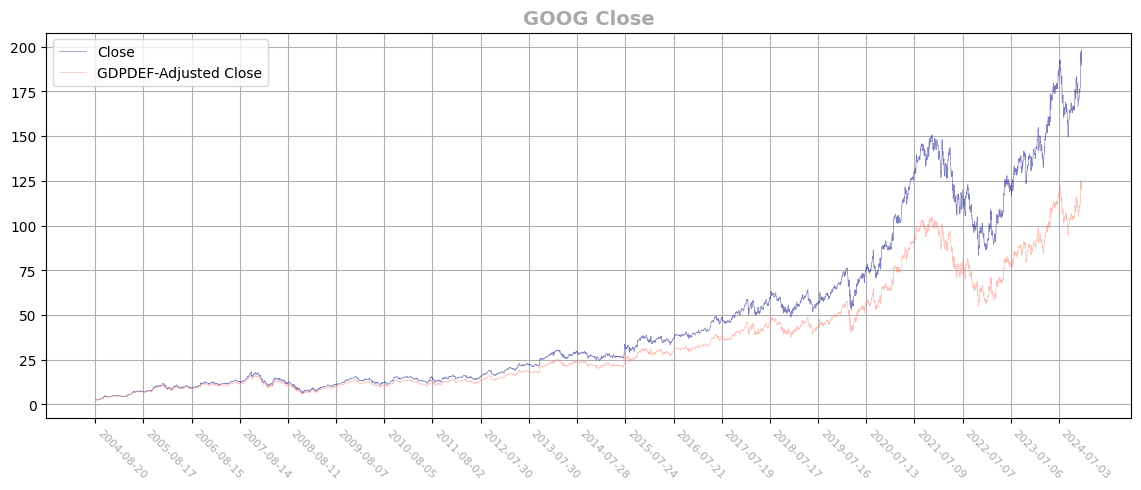

In [8]:
fig = plt.figure(figsize=(14., 5.0))
ax = fig.gca()

day = gdpdef_adj_goog_df["Day"].to_numpy()
close = gdpdef_adj_goog_df["Close"].to_numpy()
gdp_def = gdpdef_adj_goog_df["GDPDEF"].to_numpy()
gdp_def = gdp_def / gdp_def[0]
dates = gdpdef_adj_goog_df["Date"].to_numpy()

ax.set_title("GOOG Close", fontsize=14, fontweight="bold", color="darkgrey")
# ax.plot(day, gdp_def, lw=0.5, color="navy", alpha=0.5, label="gdp_def")
ax.plot(day, close, lw=0.5, color="navy", alpha=0.5, label="Close")
ax.plot(day, close / gdp_def, lw=0.5, color="salmon", alpha=0.5, label="GDPDEF-Adjusted Close")
ax.legend(loc="upper left")
ax.set_xticks(day[::250])
ax.set_xticklabels(dates[::250], fontsize=8, color="darkgrey", rotation=-45, ha="left", va="top")
ax.grid()
ax.set_axisbelow(True)

plt.show()

## Fit to Historical Close Prices:

In [9]:
day = gdpdef_adj_goog_df["Day"].to_numpy()
close = gdpdef_adj_goog_df["Close"].to_numpy()
gdp_def = gdpdef_adj_goog_df["GDPDEF"].to_numpy()
gdp_def = gdp_def / gdp_def[0]
gdpdef_adj_close = close / gdp_def
dates = gdpdef_adj_goog_df["Date"].to_numpy()
log_close = np.log(close)
log_gdpdef_adj_close = np.log(gdpdef_adj_close)

strt_date = "2010-01-01"
end_date =  "2020-01-01"
target_date = goog_df['Date'].iloc[-1]

strt_day_idx = goog_df.index[goog_df["DATETIME"] >= strt_date][0]
end_day_idx = goog_df.index[goog_df["DATETIME"] > end_date][0]
target_day_idx = goog_df.index[goog_df["DATETIME"] >= target_date][0]

print("Dates:")
print(f"\tStart Date:  {goog_df['Date'].iloc[strt_day_idx]}")
print(f"\tEnd Date:    {goog_df['Date'].iloc[end_day_idx]}")
print(f"\tTarget Date: {goog_df['Date'].iloc[target_day_idx]}")

Dates:
	Start Date:  2010-01-04
	End Date:    2020-01-02
	Target Date: 2024-12-20


In [10]:
fit_results = linregress(day[strt_day_idx:end_day_idx], log_close[strt_day_idx:end_day_idx])
fit_points = fit_results[0] * day[strt_day_idx:target_day_idx] + fit_results[1]

adj_fit_results = linregress(day[strt_day_idx:end_day_idx], log_gdpdef_adj_close[strt_day_idx:end_day_idx])
adj_fit_points = adj_fit_results[0] * day[strt_day_idx:target_day_idx] + adj_fit_results[1]

print("\tSlope:       ", np.around(fit_results[0], 7))
print("\tIntercept:   ", np.around(fit_results[1], 7))
# print("\tExp Slope: ", np.around(np.exp(fit_results[0]), 7))
print("\tEst. Annual: ", np.around(np.power(1.0 + fit_results[0], 365) - 1.0, 7))
max_log_delta = np.max(log_close[strt_day_idx:target_day_idx] - fit_points)
print("Ratio of Expected to Current: ", np.around(np.exp(fit_points[-1] - log_close[target_day_idx]), 7))
print("Max Deviation:                ", np.around(np.exp(max_log_delta), 7))

print("\nProjected Price:              ", np.around(np.exp(fit_points[-1]), 3))

	Slope:        0.0004966
	Intercept:    5.1454184
	Est. Annual:  0.1986687
Ratio of Expected to Current:  0.8877627
Max Deviation:                 1.5488093

Projected Price:               171.303


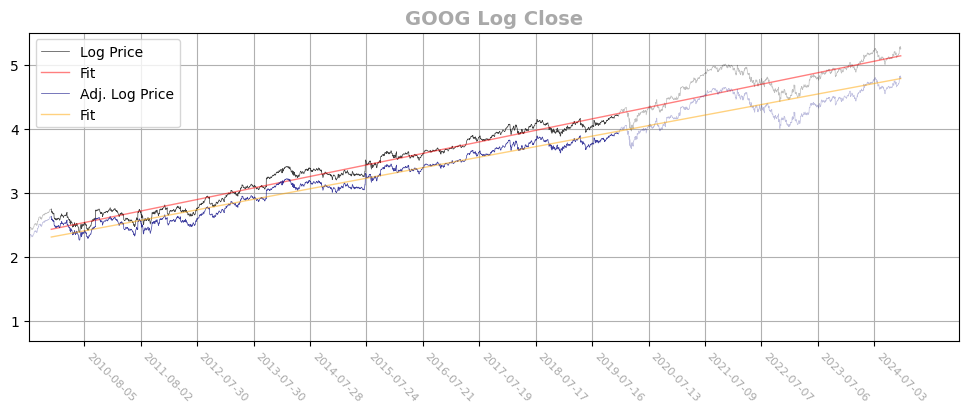

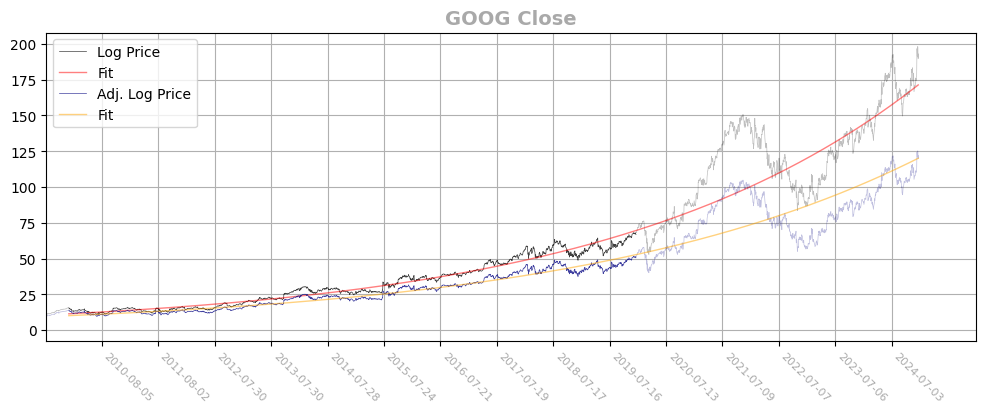

In [11]:
## Log Close Plot
fig = plt.figure(figsize=(12., 4.0))
ax = fig.gca()
#
ax.set_title("GOOG Log Close", fontsize=14, fontweight="bold", color="darkgrey")
ax.plot(day[strt_day_idx:end_day_idx], log_close[strt_day_idx:end_day_idx], 
        lw=0.5, color="black", alpha=0.75, label="Log Price")
ax.plot(day[:strt_day_idx], log_close[:strt_day_idx], lw=0.5, color="black", alpha=0.25, label=None)
ax.plot(day[end_day_idx:], log_close[end_day_idx:], lw=0.5, color="black", alpha=0.25, label=None)
ax.plot(day[strt_day_idx:target_day_idx], fit_points, lw=1.0, color="red", alpha=0.5, label="Fit")
#
ax.plot(day[strt_day_idx:end_day_idx], log_gdpdef_adj_close[strt_day_idx:end_day_idx], 
        lw=0.5, color="navy", alpha=0.75, label="Adj. Log Price")
ax.plot(day[:strt_day_idx], log_gdpdef_adj_close[:strt_day_idx], lw=0.5, color="navy", alpha=0.25, label=None)
ax.plot(day[end_day_idx:], log_gdpdef_adj_close[end_day_idx:], lw=0.5, color="navy", alpha=0.25, label=None)
ax.plot(day[strt_day_idx:target_day_idx], adj_fit_points, lw=1.0, color="orange", alpha=0.5, label="Fit")
#
ax.legend(loc="upper left")
ax.set_xticks(day[::250])
ax.set_xticklabels(dates[::250], fontsize=8, color="darkgrey", rotation=-45, ha="left", va="top")
ax.grid()
ax.set_axisbelow(True)
ax.set_xlim(day[strt_day_idx-100],)
#
plt.show()


## Close Plot
fig = plt.figure(figsize=(12., 4.0))
ax = fig.gca()
#
ax.set_title("GOOG Close", fontsize=14, fontweight="bold", color="darkgrey")
ax.plot(day[strt_day_idx:end_day_idx], close[strt_day_idx:end_day_idx], 
        lw=0.5, color="black", alpha=0.75, label="Log Price")
ax.plot(day[:strt_day_idx], close[:strt_day_idx], lw=0.5, color="black", alpha=0.25, label=None)
ax.plot(day[end_day_idx:], close[end_day_idx:], lw=0.5, color="black", alpha=0.25, label=None)
ax.plot(day[strt_day_idx:target_day_idx], np.exp(fit_points), lw=1.0, color="red", alpha=0.5, label="Fit")
#
ax.plot(day[strt_day_idx:end_day_idx], gdpdef_adj_close[strt_day_idx:end_day_idx], 
        lw=0.5, color="navy", alpha=0.75, label="Adj. Log Price")
ax.plot(day[:strt_day_idx], gdpdef_adj_close[:strt_day_idx], lw=0.5, color="navy", alpha=0.25, label=None)
ax.plot(day[end_day_idx:], gdpdef_adj_close[end_day_idx:], lw=0.5, color="navy", alpha=0.25, label=None)
ax.plot(day[strt_day_idx:target_day_idx], np.exp(adj_fit_points), lw=1.0, color="orange", alpha=0.5, label="Fit")
#
ax.legend(loc="upper left")
ax.set_xticks(day[::250])
ax.set_xticklabels(dates[::250], fontsize=8, color="darkgrey", rotation=-45, ha="left", va="top")
ax.grid()
ax.set_axisbelow(True)
ax.set_xlim(day[strt_day_idx-100],)
#
plt.show()

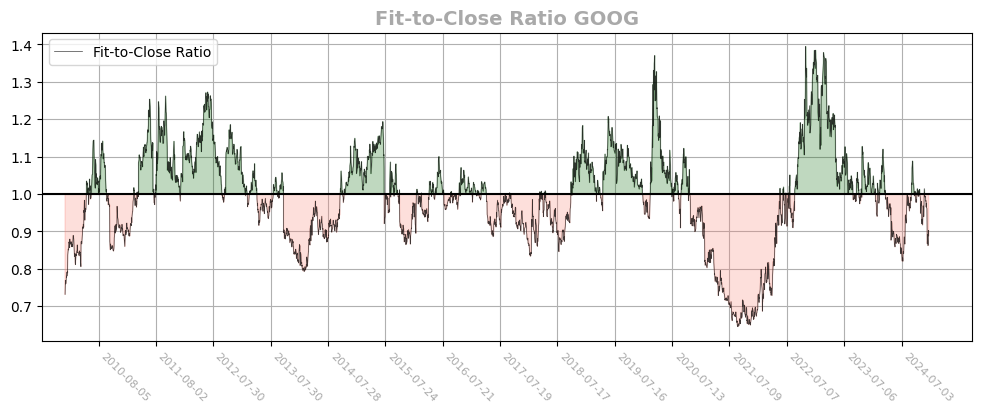

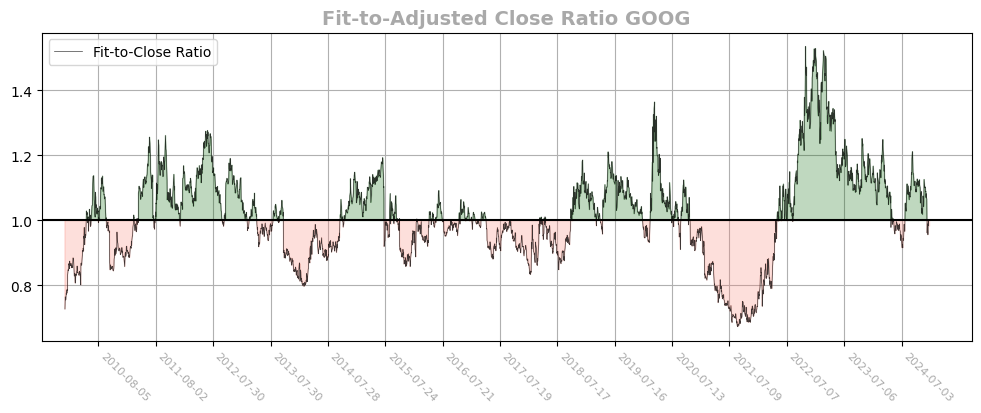

In [12]:
## Relative Close Plot
fig = plt.figure(figsize=(12., 4.0))
ax = fig.gca()
#
ax.set_title("Fit-to-Close Ratio GOOG", fontsize=14, fontweight="bold", color="darkgrey")
x = day[strt_day_idx + 1:]
y = np.exp(fit_points) / close[strt_day_idx + 1:]
ax.plot(x, y, lw=0.5, color="black", alpha=0.75, label="Fit-to-Close Ratio")
ax.fill_between(x, 1.0, y, where=(y > 1.0), color="darkgreen", alpha=0.25)
ax.fill_between(x, 1.0, y, where=(y < 1.0), color="salmon", alpha=0.25)
ax.axhline(y = 1.0, color="black", linestyle="-", lw=1.5)
ax.legend(loc="upper left")
ax.set_xticks(day[::250])
ax.set_xticklabels(dates[::250], fontsize=8, color="darkgrey", rotation=-45, ha="left", va="top")
ax.grid()
ax.set_axisbelow(True)
ax.set_xlim(day[strt_day_idx-100],)
#
plt.show()


## GDP-Adjusted Relative Close Plot
fig = plt.figure(figsize=(12., 4.0))
ax = fig.gca()
#
ax.set_title("Fit-to-Adjusted Close Ratio GOOG", fontsize=14, fontweight="bold", color="darkgrey")
x = day[strt_day_idx + 1:]
y = np.exp(adj_fit_points) / gdpdef_adj_close[strt_day_idx + 1:]
ax.plot(x, y, lw=0.5, color="black", alpha=0.75, label="Fit-to-Close Ratio")
ax.fill_between(x, 1.0, y, where=(y > 1.0), color="darkgreen", alpha=0.25)
ax.fill_between(x, 1.0, y, where=(y < 1.0), color="salmon", alpha=0.25)
ax.axhline(y = 1.0, color="black", linestyle="-", lw=1.5)
ax.legend(loc="upper left")
ax.set_xticks(day[::250])
ax.set_xticklabels(dates[::250], fontsize=8, color="darkgrey", rotation=-45, ha="left", va="top")
ax.grid()
ax.set_axisbelow(True)
ax.set_xlim(day[strt_day_idx-100],)
#
plt.show()

## Simple Averaging of the Log Returns:

In [13]:
# close = goog_df["Close"].to_numpy()
# day = goog_df["Day"].to_numpy()[:-1]
# dates = goog_df["Date"].to_numpy()[:-1]
# log_return = np.log(close[1:] / close[:-1])

# print("Log Return Mean & STD :")
# log_returns_in_range = log_return[strt_day_idx:end_day_idx]
# est_err = log_returns_in_range.std() / np.sqrt(log_returns_in_range.size)
# print(" - Daily Mean:  ", np.around(log_returns_in_range.mean(), 7), "±", np.around(est_err, 7))
# print(" - Daily STD:   ", np.around(log_returns_in_range.std(), 7))
# annual_low = np.power(1.0 + log_returns_in_range.mean() - est_err, 365) - 1.0
# annual_high = np.power(1.0 + log_returns_in_range.mean() + est_err, 365) - 1.0
# print("\nEst. Annual Growth: ", np.around(annual_low, 4), " to ", np.around(annual_high, 4))

# fig = plt.figure(figsize=(12., 5.0))
# ax = fig.gca()
# #
# ax.set_title("Log Return", fontsize=14, fontweight="bold", color="darkgrey")
# ax.plot(day[:strt_day_idx], log_return[:strt_day_idx], lw=0.5, color="darkgrey", alpha=0.5)
# ax.plot(day[strt_day_idx:end_day_idx], log_return[strt_day_idx:end_day_idx], 
#         lw=0.5, color="steelblue", alpha=0.5)
# ax.plot(day[end_day_idx:], log_return[end_day_idx:], lw=0.5, color="darkgrey", alpha=0.5)
# ax.set_xticks(day[::250])
# ax.set_xticklabels(dates[::250], fontsize=8, color="darkgrey", rotation=-45, ha="left", va="top")
# ax.grid()
# ax.set_axisbelow(True)
# #
# plt.show()

## Cummulative Gain During Period:

In [14]:
# day = goog_df["Day"].to_numpy()
# low = goog_df["Low"].to_numpy()
# high = goog_df["High"].to_numpy()
# close = goog_df["Close"].to_numpy()
# dates = goog_df["Date"].to_numpy()

# cumm_strt_date = "2018-01-01"
# cumm_end_date =  "2023-01-01"
# cumm_target_date = goog_df['Date'].iloc[-1]

# cumm_strt_day_idx = goog_df.index[goog_df["DATETIME"] >= cumm_strt_date][0]
# cumm_end_day_idx = goog_df.index[goog_df["DATETIME"] > cumm_end_date][0]
# cumm_target_day_idx = goog_df.index[goog_df["DATETIME"] >= cumm_target_date][0]

# print("Dates:")
# print(f"\tStart Date:  {goog_df['Date'].iloc[cumm_strt_day_idx]}")
# print(f"\tEnd Date:    {goog_df['Date'].iloc[cumm_end_day_idx]}")
# print(f"\tTarget Date: {goog_df['Date'].iloc[cumm_target_day_idx]}")

In [15]:
# # Compute number of shares if purchased daily with a fix amount:
# low_num_shares = np.sum(1.0 / high[cumm_strt_day_idx:cumm_end_day_idx])
# high_num_shares = np.sum(1.0 / low[cumm_strt_day_idx:cumm_end_day_idx])
# close_num_shares = np.sum(1.0 / close[cumm_strt_day_idx:cumm_end_day_idx])

# num_days = cumm_end_day_idx - cumm_strt_day_idx
# min_period_gain = low[cumm_target_day_idx] * low_num_shares / num_days
# max_period_gain = high[cumm_target_day_idx] * high_num_shares / num_days
# close_period_gain = close[cumm_target_day_idx] * close_num_shares / num_days

# print(f"\tMin Gain at Target:   {np.around(min_period_gain, 3)}")
# print(f"\tMax Gain at Target:   {np.around(max_period_gain, 3)}")
# print(f"\tClose Gain at Target: {np.around(close_period_gain, 3)}")

# annual_inflation_rate = 3.5
# inflation = np.power(1.0 + 0.01 * annual_inflation_rate, num_days / 365)
# print(f"\tInflation (at {annual_inflation_rate}% annual rate): {np.round(inflation, 2)}")

</br></br></br>

--------------------
# NASDAQ-100

In [16]:
ndx_df = pd.read_csv("csv_files/NDX.csv")

display(ndx_df.head(10))

,Date,Open,High,Low,Close,Adj Close,Volume
0,1985-10-01,110.620003,112.160004,110.565002,112.139999,112.139999,153160000
1,1985-10-02,112.139999,112.540001,110.779999,110.824997,110.824997,164640000
2,1985-10-03,110.839996,111.184998,110.120003,110.870003,110.870003,147300000
3,1985-10-04,110.870003,110.870003,109.855003,110.074997,110.074997,147900000
4,1985-10-07,110.074997,110.135002,108.175003,108.199997,108.199997,128640000
5,1985-10-08,108.199997,108.269997,106.750000,107.160004,107.160004,144100000
6,1985-10-09,107.160004,108.989998,107.114998,108.629997,108.629997,156200000
7,1985-10-10,108.629997,109.510002,107.809998,109.434998,109.434998,154840000
8,1985-10-11,109.434998,111.120003,109.425003,111.050003,111.050003,158220000
9,1985-10-14,111.050003,113.269997,111.050003,113.184998,113.184998,123120000


In [17]:
# Conver Date to DateTime Object:
ndx_df["DATETIME"] = pd.to_datetime(ndx_df["Date"], format="%Y-%m-%d")
ndx_df["Day"] = (ndx_df["DATETIME"] - pd.Timestamp.today()).dt.days

display(ndx_df.head(10))

,Date,Open,High,Low,Close,Adj Close,Volume,DATETIME,Day
0,1985-10-01,110.620003,112.160004,110.565002,112.139999,112.139999,153160000,1985-10-01,-14328
1,1985-10-02,112.139999,112.540001,110.779999,110.824997,110.824997,164640000,1985-10-02,-14327
2,1985-10-03,110.839996,111.184998,110.120003,110.870003,110.870003,147300000,1985-10-03,-14326
3,1985-10-04,110.870003,110.870003,109.855003,110.074997,110.074997,147900000,1985-10-04,-14325
4,1985-10-07,110.074997,110.135002,108.175003,108.199997,108.199997,128640000,1985-10-07,-14322
5,1985-10-08,108.199997,108.269997,106.750000,107.160004,107.160004,144100000,1985-10-08,-14321
6,1985-10-09,107.160004,108.989998,107.114998,108.629997,108.629997,156200000,1985-10-09,-14320
7,1985-10-10,108.629997,109.510002,107.809998,109.434998,109.434998,154840000,1985-10-10,-14319
8,1985-10-11,109.434998,111.120003,109.425003,111.050003,111.050003,158220000,1985-10-11,-14318
9,1985-10-14,111.050003,113.269997,111.050003,113.184998,113.184998,123120000,1985-10-14,-14315


## Adjust by GDP Deflator:

In [18]:
# Merge DataFrames:
gdpdef_adj_ndx_df = pd.merge(
    left=ndx_df[["Close", "DATETIME", "Date", "Day"]],
    right=gdpdef_df[["GDPDEF", "DATETIME", "Date", "Day"]], 
    how="outer", sort=True, on="Day")

# Interpolate:
gdpdef_adj_ndx_df["GDPDEF"] = gdpdef_adj_ndx_df["GDPDEF"].interpolate(
    method="linear", limit_direction="forward", axis=0)

# Drop rows outside of Goog DATETIME
gdpdef_adj_ndx_df = gdpdef_adj_ndx_df[gdpdef_adj_ndx_df["Close"].notna()]

# Use the Goog DATETIME:
gdpdef_adj_ndx_df = gdpdef_adj_ndx_df.rename(columns={
        "DATETIME_x": "DATETIME",
        "Date_x": "Date"
})

# Drop columns:
gdpdef_adj_ndx_df = gdpdef_adj_ndx_df.drop(["DATETIME_y", "Date_y"], axis=1, inplace=False)

## Plot:

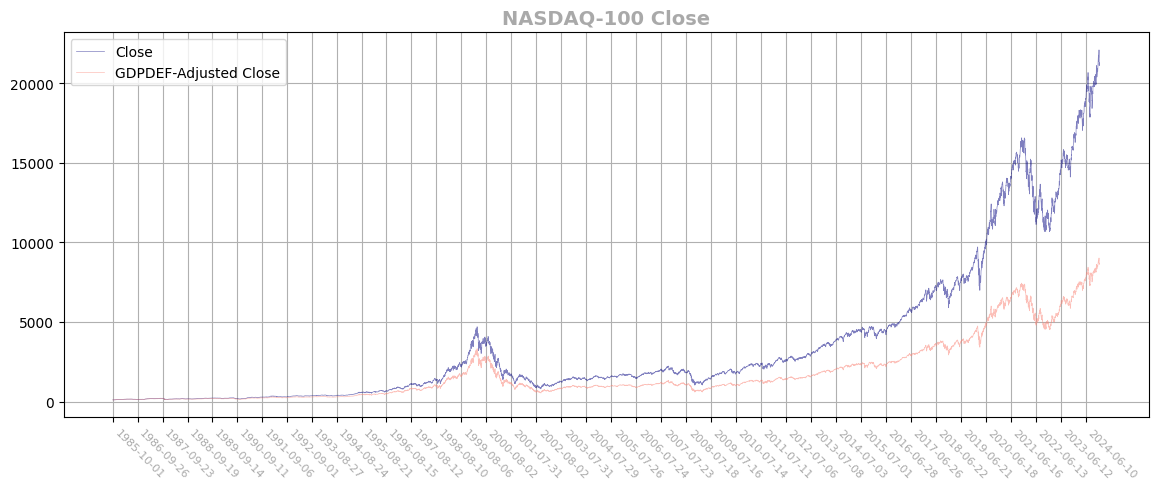

In [19]:
fig = plt.figure(figsize=(14., 5.0))
ax = fig.gca()

day = gdpdef_adj_ndx_df["Day"].to_numpy()
close = gdpdef_adj_ndx_df["Close"].to_numpy()
gdp_def = gdpdef_adj_ndx_df["GDPDEF"].to_numpy()
gdp_def = gdp_def / gdp_def[0]
dates = gdpdef_adj_ndx_df["Date"].to_numpy()

ax.set_title("NASDAQ-100 Close", fontsize=14, fontweight="bold", color="darkgrey")
# ax.plot(day, gdp_def, lw=0.5, color="navy", alpha=0.5, label="gdp_def")
ax.plot(day, close, lw=0.5, color="navy", alpha=0.5, label="Close")
ax.plot(day, close / gdp_def, lw=0.5, color="salmon", alpha=0.5, label="GDPDEF-Adjusted Close")
ax.legend(loc="upper left")
ax.set_xticks(day[::250])
ax.set_xticklabels(dates[::250], fontsize=8, color="darkgrey", rotation=-45, ha="left", va="top")
ax.grid()
ax.set_axisbelow(True)

plt.show()

## Fit to Historical Close Prices:

In [20]:
day = gdpdef_adj_ndx_df["Day"].to_numpy()
close = gdpdef_adj_ndx_df["Close"].to_numpy()
gdp_def = gdpdef_adj_ndx_df["GDPDEF"].to_numpy()
gdp_def = gdp_def / gdp_def[0]
gdpdef_adj_close = close / gdp_def
dates = gdpdef_adj_ndx_df["Date"].to_numpy()
log_close = np.log(close)
log_gdpdef_adj_close = np.log(gdpdef_adj_close)

strt_date = "2010-01-01"
end_date = "2020-01-01"
target_date = ndx_df['Date'].iloc[-1]

strt_day_idx = ndx_df.index[ndx_df["DATETIME"] >= strt_date][0]
end_day_idx = ndx_df.index[ndx_df["DATETIME"] > end_date][0]
target_day_idx = ndx_df.index[ndx_df["DATETIME"] >= target_date][0]

print("Dates:")
print(f"\tStart Date:  {ndx_df['Date'].iloc[strt_day_idx]}")
print(f"\tEnd Date:    {ndx_df['Date'].iloc[end_day_idx]}")
print(f"\tTarget Date: {ndx_df['Date'].iloc[target_day_idx]}")

Dates:
	Start Date:  2010-01-04
	End Date:    2020-01-02
	Target Date: 2024-12-20


In [21]:
fit_results = linregress(day[strt_day_idx:end_day_idx], log_close[strt_day_idx:end_day_idx])
fit_points = fit_results[0] * day[strt_day_idx:target_day_idx] + fit_results[1]

adj_fit_results = linregress(day[strt_day_idx:end_day_idx], log_gdpdef_adj_close[strt_day_idx:end_day_idx])
adj_fit_points = adj_fit_results[0] * day[strt_day_idx:target_day_idx] + adj_fit_results[1]

print("\tSlope:       ", np.around(fit_results[0], 7))
print("\tIntercept:   ", np.around(fit_results[1], 7))
# print("\tExp Slope: ", np.around(np.exp(fit_results[0]), 7))
print("\tEst. Annual: ", np.around(np.power(1.0 + fit_results[0], 365) - 1.0, 7))
max_log_delta = np.max(log_close[strt_day_idx:target_day_idx] - fit_points)
print("Ratio of Expected to Current: ", np.around(np.exp(fit_points[-1] - log_close[target_day_idx]), 7))
print("Max Deviation:                ", np.around(np.exp(max_log_delta), 7))

print("\nProjected Price:              ", np.around(np.exp(fit_points[-1]), 3))

	Slope:        0.0004202
	Intercept:    9.8041581
	Est. Annual:  0.1657339
Ratio of Expected to Current:  0.8491872
Max Deviation:                 1.471452

Projected Price:               18078.474


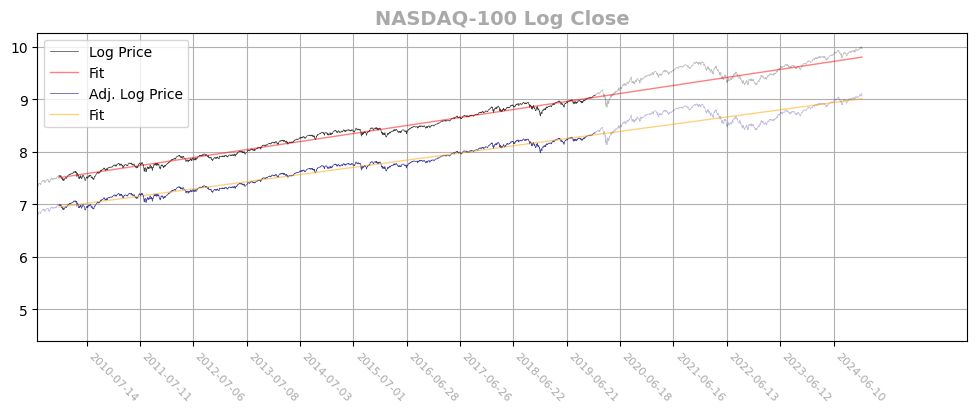

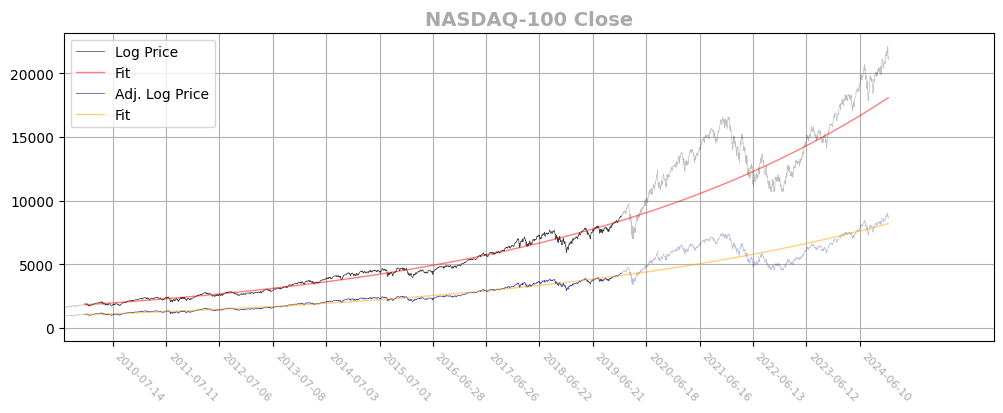

In [22]:
## Log Close Plot
fig = plt.figure(figsize=(12., 4.0))
ax = fig.gca()
#
ax.set_title("NASDAQ-100 Log Close", fontsize=14, fontweight="bold", color="darkgrey")
ax.plot(day[strt_day_idx:end_day_idx], log_close[strt_day_idx:end_day_idx], 
        lw=0.5, color="black", alpha=0.75, label="Log Price")
ax.plot(day[:strt_day_idx], log_close[:strt_day_idx], lw=0.5, color="black", alpha=0.25, label=None)
ax.plot(day[end_day_idx:], log_close[end_day_idx:], lw=0.5, color="black", alpha=0.25, label=None)
ax.plot(day[strt_day_idx:target_day_idx], fit_points, lw=1.0, color="red", alpha=0.5, label="Fit")
#
ax.plot(day[strt_day_idx:end_day_idx], log_gdpdef_adj_close[strt_day_idx:end_day_idx], 
        lw=0.5, color="navy", alpha=0.75, label="Adj. Log Price")
ax.plot(day[:strt_day_idx], log_gdpdef_adj_close[:strt_day_idx], lw=0.5, color="navy", alpha=0.25, label=None)
ax.plot(day[end_day_idx:], log_gdpdef_adj_close[end_day_idx:], lw=0.5, color="navy", alpha=0.25, label=None)
ax.plot(day[strt_day_idx:target_day_idx], adj_fit_points, lw=1.0, color="orange", alpha=0.5, label="Fit")
#
ax.legend(loc="upper left")
ax.set_xticks(day[::250])
ax.set_xticklabels(dates[::250], fontsize=8, color="darkgrey", rotation=-45, ha="left", va="top")
ax.grid()
ax.set_axisbelow(True)
ax.set_xlim(day[strt_day_idx-100],)
#
plt.show()


## Close Plot
fig = plt.figure(figsize=(12., 4.0))
ax = fig.gca()
#
ax.set_title("NASDAQ-100 Close", fontsize=14, fontweight="bold", color="darkgrey")
ax.plot(day[strt_day_idx:end_day_idx], close[strt_day_idx:end_day_idx], 
        lw=0.5, color="black", alpha=0.75, label="Log Price")
ax.plot(day[:strt_day_idx], close[:strt_day_idx], lw=0.5, color="black", alpha=0.25, label=None)
ax.plot(day[end_day_idx:], close[end_day_idx:], lw=0.5, color="black", alpha=0.25, label=None)
ax.plot(day[strt_day_idx:target_day_idx], np.exp(fit_points), lw=1.0, color="red", alpha=0.5, label="Fit")
#
ax.plot(day[strt_day_idx:end_day_idx], gdpdef_adj_close[strt_day_idx:end_day_idx], 
        lw=0.5, color="navy", alpha=0.75, label="Adj. Log Price")
ax.plot(day[:strt_day_idx], gdpdef_adj_close[:strt_day_idx], lw=0.5, color="navy", alpha=0.25, label=None)
ax.plot(day[end_day_idx:], gdpdef_adj_close[end_day_idx:], lw=0.5, color="navy", alpha=0.25, label=None)
ax.plot(day[strt_day_idx:target_day_idx], np.exp(adj_fit_points), lw=1.0, color="orange", alpha=0.5, label="Fit")
#
ax.legend(loc="upper left")
ax.set_xticks(day[::250])
ax.set_xticklabels(dates[::250], fontsize=8, color="darkgrey", rotation=-45, ha="left", va="top")
ax.grid()
ax.set_axisbelow(True)
ax.set_xlim(day[strt_day_idx-100],)
#
plt.show()

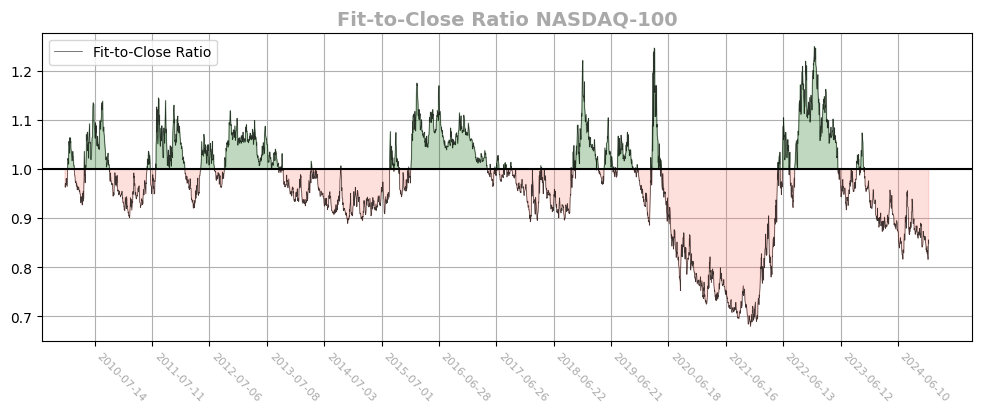

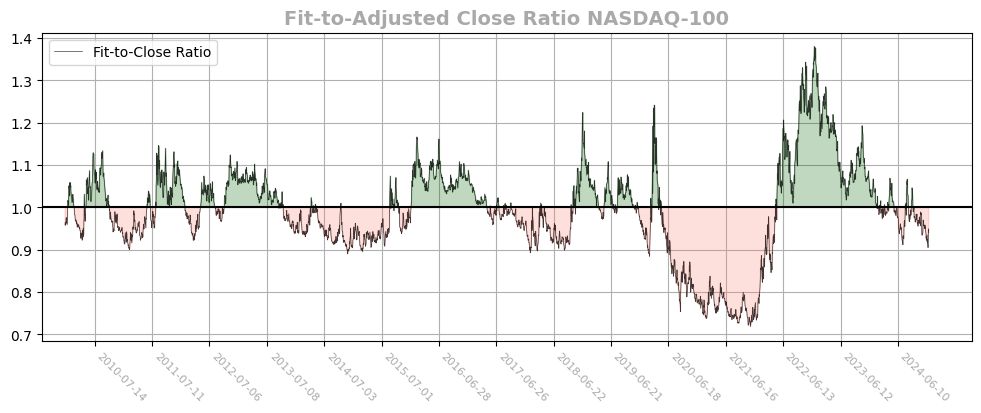

In [23]:
## Relative Close Plot
fig = plt.figure(figsize=(12., 4.0))
ax = fig.gca()
#
ax.set_title("Fit-to-Close Ratio NASDAQ-100", fontsize=14, fontweight="bold", color="darkgrey")
x = day[strt_day_idx + 1:]
y = np.exp(fit_points) / close[strt_day_idx + 1:]
ax.plot(x, y, lw=0.5, color="black", alpha=0.75, label="Fit-to-Close Ratio")
ax.fill_between(x, 1.0, y, where=(y > 1.0), color="darkgreen", alpha=0.25)
ax.fill_between(x, 1.0, y, where=(y < 1.0), color="salmon", alpha=0.25)
ax.axhline(y = 1.0, color="black", linestyle="-", lw=1.5)
ax.legend(loc="upper left")
ax.set_xticks(day[::250])
ax.set_xticklabels(dates[::250], fontsize=8, color="darkgrey", rotation=-45, ha="left", va="top")
ax.grid()
ax.set_axisbelow(True)
ax.set_xlim(day[strt_day_idx-100],)
#
plt.show()


## GDP-Adjusted Relative Close Plot
fig = plt.figure(figsize=(12., 4.0))
ax = fig.gca()
#
ax.set_title("Fit-to-Adjusted Close Ratio NASDAQ-100", fontsize=14, fontweight="bold", color="darkgrey")
x = day[strt_day_idx + 1:]
y = np.exp(adj_fit_points) / gdpdef_adj_close[strt_day_idx + 1:]
ax.plot(x, y, lw=0.5, color="black", alpha=0.75, label="Fit-to-Close Ratio")
ax.fill_between(x, 1.0, y, where=(y > 1.0), color="darkgreen", alpha=0.25)
ax.fill_between(x, 1.0, y, where=(y < 1.0), color="salmon", alpha=0.25)
ax.axhline(y = 1.0, color="black", linestyle="-", lw=1.5)
ax.legend(loc="upper left")
ax.set_xticks(day[::250])
ax.set_xticklabels(dates[::250], fontsize=8, color="darkgrey", rotation=-45, ha="left", va="top")
ax.grid()
ax.set_axisbelow(True)
ax.set_xlim(day[strt_day_idx-100],)
#
plt.show()

## Simple Averaging of the Log Returns:

In [24]:
# close = ndx_df["Close"].to_numpy()
# day = ndx_df["Day"].to_numpy()[:-1]
# dates = ndx_df["Date"].to_numpy()[:-1]
# log_return = np.log(close[1:] / close[:-1])

# print("Log Return Mean & STD :")
# log_returns_in_range = log_return[strt_day_idx:end_day_idx]
# est_err = log_returns_in_range.std() / np.sqrt(log_returns_in_range.size)
# print(" - Mean: ", np.around(log_returns_in_range.mean(), 7), "±", np.around(est_err, 7))
# print(" - STD:  ", np.around(log_returns_in_range.std(), 7))

# fig = plt.figure(figsize=(12., 5.0))
# ax = fig.gca()
# #
# ax.set_title("Log Return", fontsize=14, fontweight="bold", color="darkgrey")
# ax.plot(day[:strt_day_idx], log_return[:strt_day_idx], lw=0.5, color="darkgrey", alpha=0.5)
# ax.plot(day[strt_day_idx:end_day_idx], log_return[strt_day_idx:end_day_idx], 
#         lw=0.5, color="steelblue", alpha=0.5)
# ax.plot(day[end_day_idx:], log_return[end_day_idx:], lw=0.5, color="darkgrey", alpha=0.5)
# ax.set_xticks(day[::250])
# ax.set_xticklabels(dates[::250], fontsize=8, color="darkgrey", rotation=-45, ha="left", va="top")
# ax.grid()
# ax.set_axisbelow(True)
# #
# plt.show()

## Cummulative Gain During Period:

In [25]:
# day = ndx_df["Day"].to_numpy()
# low = ndx_df["Low"].to_numpy()
# high = ndx_df["High"].to_numpy()
# close = ndx_df["Close"].to_numpy()
# dates = ndx_df["Date"].to_numpy()

# cumm_strt_date = "2018-01-01"
# cumm_end_date =  "2023-01-01"
# cumm_target_date = ndx_df['Date'].iloc[-1]

# cumm_strt_day_idx = ndx_df.index[ndx_df["DATETIME"] >= cumm_strt_date][0]
# cumm_end_day_idx = ndx_df.index[ndx_df["DATETIME"] > cumm_end_date][0]
# cumm_target_day_idx = ndx_df.index[ndx_df["DATETIME"] >= cumm_target_date][0]

# print("Dates:")
# print(f"\tStart Date:  {ndx_df['Date'].iloc[cumm_strt_day_idx]}")
# print(f"\tEnd Date:    {ndx_df['Date'].iloc[cumm_end_day_idx]}")
# print(f"\tTarget Date: {ndx_df['Date'].iloc[cumm_target_day_idx]}")

In [26]:
# # Compute number of shares if purchased daily with a fix amount:
# low_num_shares = np.sum(1.0 / high[cumm_strt_day_idx:cumm_end_day_idx])
# high_num_shares = np.sum(1.0 / low[cumm_strt_day_idx:cumm_end_day_idx])
# close_num_shares = np.sum(1.0 / close[cumm_strt_day_idx:cumm_end_day_idx])

# num_days = cumm_end_day_idx - cumm_strt_day_idx
# min_period_gain = low[cumm_target_day_idx] * low_num_shares / num_days
# max_period_gain = high[cumm_target_day_idx] * high_num_shares / num_days
# close_period_gain = close[cumm_target_day_idx] * close_num_shares / num_days

# print(f"\tMin Gain at Target:   {np.around(min_period_gain, 3)}")
# print(f"\tMax Gain at Target:   {np.around(max_period_gain, 3)}")
# print(f"\tClose Gain at Target: {np.around(close_period_gain, 3)}")

# annual_inflation_rate = 3.5
# inflation = np.power(1.0 + 0.01 * annual_inflation_rate, num_days / 365)
# print(f"\tInflation (at {annual_inflation_rate}% annual rate): {np.round(inflation, 2)}")

</br></br></br>

--------------------
# Dow Jones

In [27]:
dji_df = pd.read_csv("csv_files/DJI.csv")

display(dji_df.head(10))
display(len(dji_df.index))

,Date,Open,High,Low,Close,Adj Close,Volume
0,1992-01-02,3152.100098,3172.629883,3139.310059,3172.399902,3172.399902,23550000
1,1992-01-03,3172.399902,3210.639893,3165.919922,3201.500000,3201.500000,23620000
2,1992-01-06,3201.500000,3213.330078,3191.860107,3200.100098,3200.100098,27280000
3,1992-01-07,3200.100098,3210.199951,3184.479980,3204.800049,3204.800049,25510000
4,1992-01-08,3204.800049,3229.199951,3185.820068,3203.899902,3203.899902,29040000
5,1992-01-09,3203.899902,3228.310059,3192.750000,3209.500000,3209.500000,29820000
6,1992-01-10,3209.500000,3217.129883,3185.379883,3199.500000,3199.500000,23440000
7,1992-01-13,3199.500000,3201.250000,3179.110107,3185.600098,3185.600098,19300000
8,1992-01-14,3185.600098,3248.879883,3182.919922,3246.199951,3246.199951,24220000
9,1992-01-15,3246.199951,3263.419922,3232.110107,3258.500000,3258.500000,29560000


8305

In [28]:
# Remove duplicates:
dji_df = dji_df.drop_duplicates("Date")
display(len(dji_df.index))

# Reset Index:
dji_df.reset_index(drop=True, inplace=True)

8305

In [29]:
# Conver Date to DateTime Object:
dji_df["DATETIME"] = pd.to_datetime(dji_df["Date"], format="%Y-%m-%d")
dji_df["Day"] = (dji_df["DATETIME"] - pd.Timestamp.today()).dt.days

display(dji_df.head(10))
display(len(dji_df.index))

,Date,Open,High,Low,Close,Adj Close,Volume,DATETIME,Day
0,1992-01-02,3152.100098,3172.629883,3139.310059,3172.399902,3172.399902,23550000,1992-01-02,-12044
1,1992-01-03,3172.399902,3210.639893,3165.919922,3201.500000,3201.500000,23620000,1992-01-03,-12043
2,1992-01-06,3201.500000,3213.330078,3191.860107,3200.100098,3200.100098,27280000,1992-01-06,-12040
3,1992-01-07,3200.100098,3210.199951,3184.479980,3204.800049,3204.800049,25510000,1992-01-07,-12039
4,1992-01-08,3204.800049,3229.199951,3185.820068,3203.899902,3203.899902,29040000,1992-01-08,-12038
5,1992-01-09,3203.899902,3228.310059,3192.750000,3209.500000,3209.500000,29820000,1992-01-09,-12037
6,1992-01-10,3209.500000,3217.129883,3185.379883,3199.500000,3199.500000,23440000,1992-01-10,-12036
7,1992-01-13,3199.500000,3201.250000,3179.110107,3185.600098,3185.600098,19300000,1992-01-13,-12033
8,1992-01-14,3185.600098,3248.879883,3182.919922,3246.199951,3246.199951,24220000,1992-01-14,-12032
9,1992-01-15,3246.199951,3263.419922,3232.110107,3258.500000,3258.500000,29560000,1992-01-15,-12031


8305

## Adjust by GDP Deflator:

In [30]:
# Merge DataFrames:
gdpdef_adj_dji_df = pd.merge(
    left=dji_df[["Close", "DATETIME", "Date", "Day"]],
    right=gdpdef_df[["GDPDEF", "DATETIME", "Date", "Day"]], 
    how="outer", sort=True, on="Day")

# Interpolate:
gdpdef_adj_dji_df["GDPDEF"] = gdpdef_adj_dji_df["GDPDEF"].interpolate(
    method="linear", limit_direction="forward", axis=0)

# Drop rows outside of Goog DATETIME
gdpdef_adj_dji_df = gdpdef_adj_dji_df[gdpdef_adj_dji_df["Close"].notna()]

# Use the Goog DATETIME:
gdpdef_adj_dji_df = gdpdef_adj_dji_df.rename(columns={
        "DATETIME_x": "DATETIME",
        "Date_x": "Date"
})

# Drop columns:
gdpdef_adj_dji_df = gdpdef_adj_dji_df.drop(["DATETIME_y", "Date_y"], axis=1, inplace=False)

## Plot:

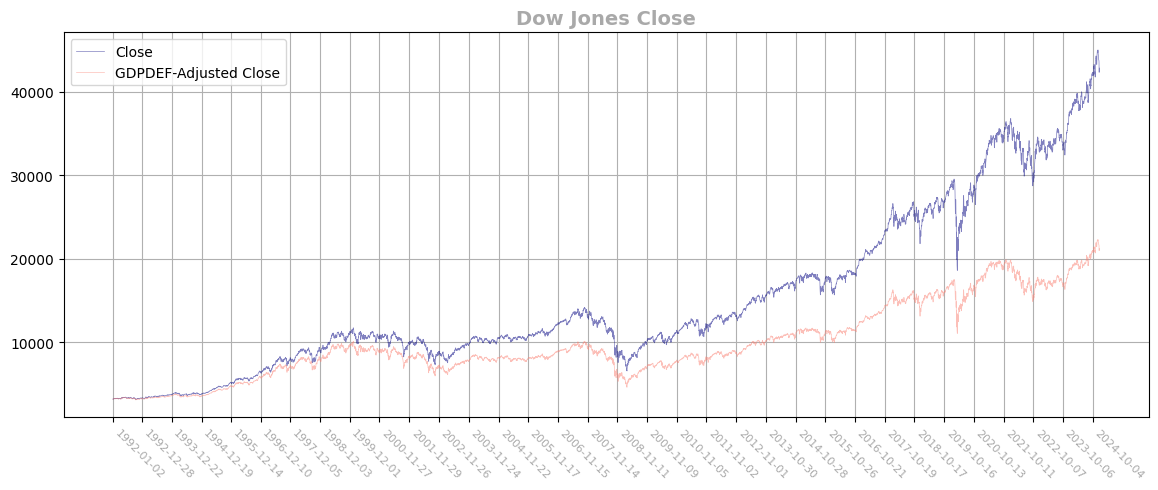

In [31]:
fig = plt.figure(figsize=(14., 5.0))
ax = fig.gca()

day = gdpdef_adj_dji_df["Day"].to_numpy()
close = gdpdef_adj_dji_df["Close"].to_numpy()
gdp_def = gdpdef_adj_dji_df["GDPDEF"].to_numpy()
gdp_def = gdp_def / gdp_def[0]
dates = gdpdef_adj_dji_df["Date"].to_numpy()

ax.set_title("Dow Jones Close", fontsize=14, fontweight="bold", color="darkgrey")
# ax.plot(day, gdp_def, lw=0.5, color="navy", alpha=0.5, label="gdp_def")
ax.plot(day, close, lw=0.5, color="navy", alpha=0.5, label="Close")
ax.plot(day, close / gdp_def, lw=0.5, color="salmon", alpha=0.5, label="GDPDEF-Adjusted Close")
ax.legend(loc="upper left")
ax.set_xticks(day[::250])
ax.set_xticklabels(dates[::250], fontsize=8, color="darkgrey", rotation=-45, ha="left", va="top")
ax.grid()
ax.set_axisbelow(True)

plt.show()


## Fit to Historical Close Prices:

In [32]:
day = gdpdef_adj_dji_df["Day"].to_numpy()
close = gdpdef_adj_dji_df["Close"].to_numpy()
gdp_def = gdpdef_adj_dji_df["GDPDEF"].to_numpy()
gdp_def = gdp_def / gdp_def[0]
gdpdef_adj_close = close / gdp_def
dates = gdpdef_adj_dji_df["Date"].to_numpy()
log_close = np.log(close)
log_gdpdef_adj_close = np.log(gdpdef_adj_close)

strt_date = "2010-01-01"
end_date = "2020-01-01"
target_date = dji_df['Date'].iloc[-1]

strt_day_idx = dji_df.index[dji_df["DATETIME"] >= strt_date][0]
end_day_idx = dji_df.index[dji_df["DATETIME"] > end_date][0]
target_day_idx = dji_df.index[dji_df["DATETIME"] >= target_date][0]

print("Dates:")
print(f"\tStart Date:  {dji_df['Date'].iloc[strt_day_idx]}")
print(f"\tEnd Date:    {dji_df['Date'].iloc[end_day_idx]}")
print(f"\tTarget Date: {dji_df['Date'].iloc[target_day_idx]}")

Dates:
	Start Date:  2010-01-04
	End Date:    2020-01-02
	Target Date: 2024-12-20


In [33]:
fit_results = linregress(day[strt_day_idx:end_day_idx], log_close[strt_day_idx:end_day_idx])
fit_points = fit_results[0] * day[strt_day_idx:target_day_idx] + fit_results[1]

adj_fit_results = linregress(day[strt_day_idx:end_day_idx], log_gdpdef_adj_close[strt_day_idx:end_day_idx])
adj_fit_points = adj_fit_results[0] * day[strt_day_idx:target_day_idx] + adj_fit_results[1]

print("\tSlope:       ", np.around(fit_results[0], 7))
print("\tIntercept:   ", np.around(fit_results[1], 7))
# print("\tExp Slope:   ", np.around(np.exp(fit_results[0]), 7))
print("\tEst. Annual: ", np.around(np.power(1.0 + fit_results[0], 365) - 1.0, 7))
max_log_delta = np.max(log_close[strt_day_idx:target_day_idx]-fit_points)
print("Ratio of Expected to Current: ", np.around(np.exp(fit_points[-1] - log_close[target_day_idx]), 7))
print("Max Deviation:                ", np.around(np.exp(max_log_delta), 7))

print("\nProjected Price:              ", np.around(np.exp(fit_points[-1]), 3))

	Slope:        0.0002729
	Intercept:    10.7279661
	Est. Annual:  0.1047305
Ratio of Expected to Current:  1.0635802
Max Deviation:                 1.1617182

Projected Price:               45564.054


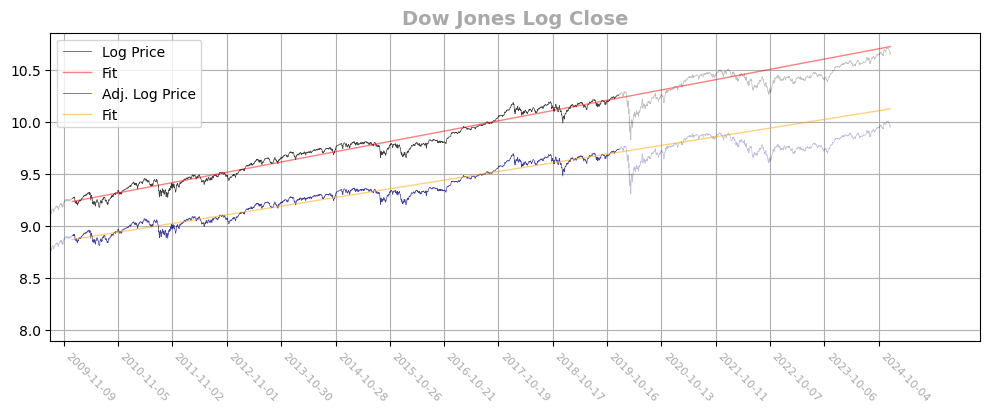

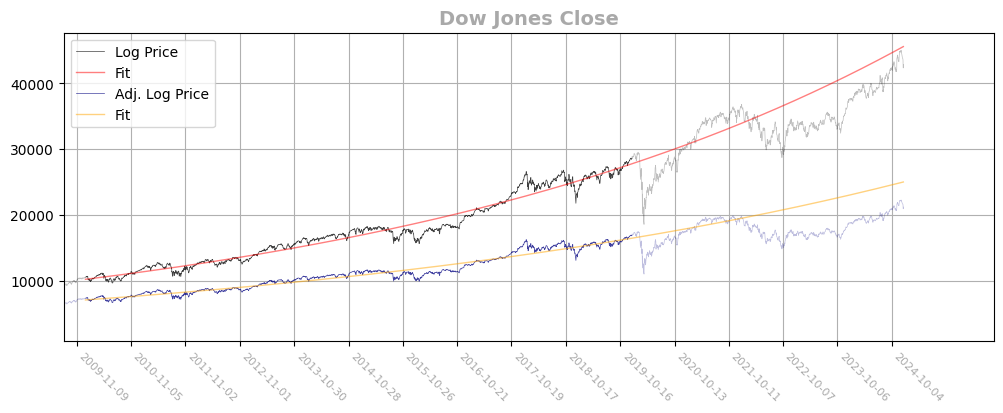

In [34]:
## Log Close Plot
fig = plt.figure(figsize=(12., 4.0))
ax = fig.gca()
#
ax.set_title("Dow Jones Log Close", fontsize=14, fontweight="bold", color="darkgrey")
ax.plot(day[strt_day_idx:end_day_idx], log_close[strt_day_idx:end_day_idx], 
        lw=0.5, color="black", alpha=0.75, label="Log Price")
ax.plot(day[:strt_day_idx], log_close[:strt_day_idx], lw=0.5, color="black", alpha=0.25, label=None)
ax.plot(day[end_day_idx:], log_close[end_day_idx:], lw=0.5, color="black", alpha=0.25, label=None)
ax.plot(day[strt_day_idx:target_day_idx], fit_points, lw=1.0, color="red", alpha=0.5, label="Fit")
#
ax.plot(day[strt_day_idx:end_day_idx], log_gdpdef_adj_close[strt_day_idx:end_day_idx], 
        lw=0.5, color="navy", alpha=0.75, label="Adj. Log Price")
ax.plot(day[:strt_day_idx], log_gdpdef_adj_close[:strt_day_idx], lw=0.5, color="navy", alpha=0.25, label=None)
ax.plot(day[end_day_idx:], log_gdpdef_adj_close[end_day_idx:], lw=0.5, color="navy", alpha=0.25, label=None)
ax.plot(day[strt_day_idx:target_day_idx], adj_fit_points, lw=1.0, color="orange", alpha=0.5, label="Fit")
#
ax.legend(loc="upper left")
ax.set_xticks(day[::250])
ax.set_xticklabels(dates[::250], fontsize=8, color="darkgrey", rotation=-45, ha="left", va="top")
ax.grid()
ax.set_axisbelow(True)
ax.set_xlim(day[strt_day_idx-100],)
#
plt.show()


## Close Plot
fig = plt.figure(figsize=(12., 4.0))
ax = fig.gca()
#
ax.set_title("Dow Jones Close", fontsize=14, fontweight="bold", color="darkgrey")
ax.plot(day[strt_day_idx:end_day_idx], close[strt_day_idx:end_day_idx], 
        lw=0.5, color="black", alpha=0.75, label="Log Price")
ax.plot(day[:strt_day_idx], close[:strt_day_idx], lw=0.5, color="black", alpha=0.25, label=None)
ax.plot(day[end_day_idx:], close[end_day_idx:], lw=0.5, color="black", alpha=0.25, label=None)
ax.plot(day[strt_day_idx:target_day_idx], np.exp(fit_points), lw=1.0, color="red", alpha=0.5, label="Fit")
#
ax.plot(day[strt_day_idx:end_day_idx], gdpdef_adj_close[strt_day_idx:end_day_idx], 
        lw=0.5, color="navy", alpha=0.75, label="Adj. Log Price")
ax.plot(day[:strt_day_idx], gdpdef_adj_close[:strt_day_idx], lw=0.5, color="navy", alpha=0.25, label=None)
ax.plot(day[end_day_idx:], gdpdef_adj_close[end_day_idx:], lw=0.5, color="navy", alpha=0.25, label=None)
ax.plot(day[strt_day_idx:target_day_idx], np.exp(adj_fit_points), lw=1.0, color="orange", alpha=0.5, label="Fit")
#
ax.legend(loc="upper left")
ax.set_xticks(day[::250])
ax.set_xticklabels(dates[::250], fontsize=8, color="darkgrey", rotation=-45, ha="left", va="top")
ax.grid()
ax.set_axisbelow(True)
ax.set_xlim(day[strt_day_idx-100],)
#
plt.show()

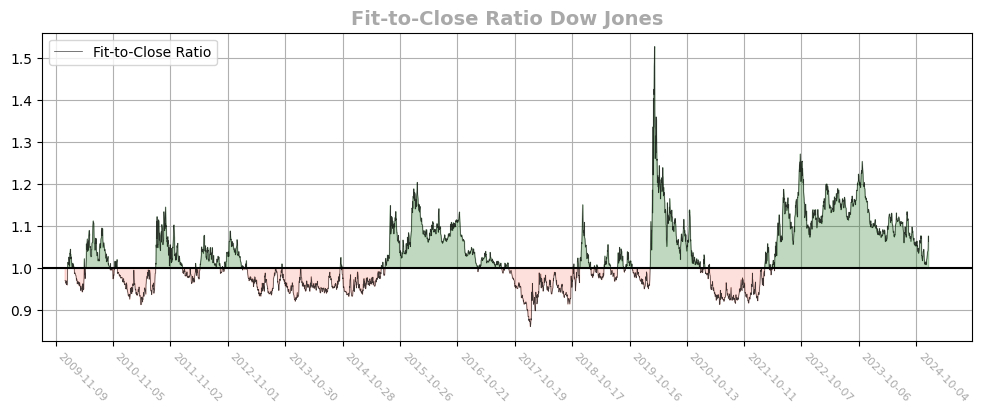

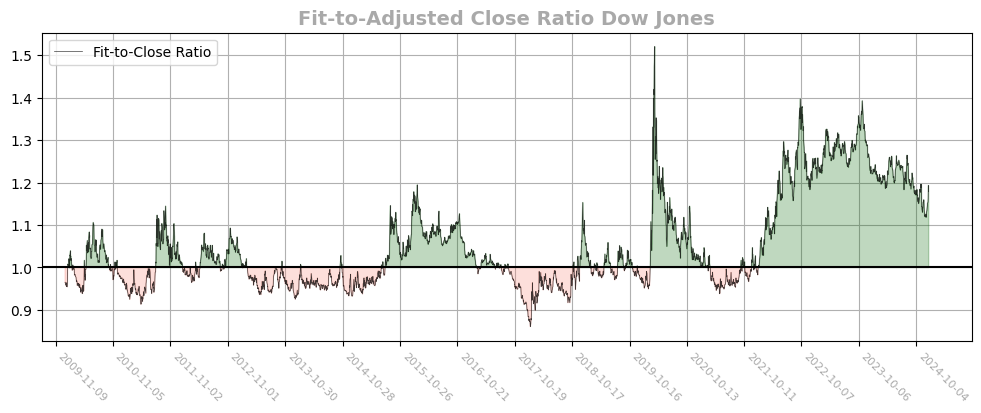

In [35]:
## Relative Close Plot
fig = plt.figure(figsize=(12., 4.0))
ax = fig.gca()
#
ax.set_title("Fit-to-Close Ratio Dow Jones", fontsize=14, fontweight="bold", color="darkgrey")
x = day[strt_day_idx + 1:]
y = np.exp(fit_points) / close[strt_day_idx + 1:]
ax.plot(x, y, lw=0.5, color="black", alpha=0.75, label="Fit-to-Close Ratio")
ax.fill_between(x, 1.0, y, where=(y > 1.0), color="darkgreen", alpha=0.25)
ax.fill_between(x, 1.0, y, where=(y < 1.0), color="salmon", alpha=0.25)
ax.axhline(y = 1.0, color="black", linestyle="-", lw=1.5)
ax.legend(loc="upper left")
ax.set_xticks(day[::250])
ax.set_xticklabels(dates[::250], fontsize=8, color="darkgrey", rotation=-45, ha="left", va="top")
ax.grid()
ax.set_axisbelow(True)
ax.set_xlim(day[strt_day_idx-100],)
#
plt.show()


## GDP-Adjusted Relative Close Plot
fig = plt.figure(figsize=(12., 4.0))
ax = fig.gca()
#
ax.set_title("Fit-to-Adjusted Close Ratio Dow Jones", fontsize=14, fontweight="bold", color="darkgrey")
x = day[strt_day_idx + 1:]
y = np.exp(adj_fit_points) / gdpdef_adj_close[strt_day_idx + 1:]
ax.plot(x, y, lw=0.5, color="black", alpha=0.75, label="Fit-to-Close Ratio")
ax.fill_between(x, 1.0, y, where=(y > 1.0), color="darkgreen", alpha=0.25)
ax.fill_between(x, 1.0, y, where=(y < 1.0), color="salmon", alpha=0.25)
ax.axhline(y = 1.0, color="black", linestyle="-", lw=1.5)
ax.legend(loc="upper left")
ax.set_xticks(day[::250])
ax.set_xticklabels(dates[::250], fontsize=8, color="darkgrey", rotation=-45, ha="left", va="top")
ax.grid()
ax.set_axisbelow(True)
ax.set_xlim(day[strt_day_idx-100],)
#
plt.show()

## Simple Averaging of Log Returns:

In [36]:
# close = dji_df["Close"].to_numpy()
# day = dji_df["Day"].to_numpy()[:-1]
# dates = dji_df["Date"].to_numpy()[:-1]
# log_return = np.log(close[1:] / close[:-1])

# print("Log Return Mean & STD :")
# log_returns_in_range = log_return[strt_day_idx:end_day_idx]
# est_err = log_returns_in_range.std() / np.sqrt(log_returns_in_range.size)
# print(" - Mean: ", np.around(log_returns_in_range.mean(), 7), "±", np.around(est_err, 7))
# print(" - STD:  ", np.around(log_returns_in_range.std(), 7))


# fig = plt.figure(figsize=(12., 4.0))
# ax = fig.gca()
# #
# ax.set_title("Log Return", fontsize=14, fontweight="bold", color="darkgrey")
# ax.plot(day[:strt_day_idx], log_return[:strt_day_idx], lw=0.5, color="darkgrey", alpha=0.5)
# ax.plot(day[strt_day_idx:end_day_idx], log_return[strt_day_idx:end_day_idx], 
#         lw=0.5, color="steelblue", alpha=0.5)
# ax.plot(day[end_day_idx:], log_return[end_day_idx:], lw=0.5, color="darkgrey", alpha=0.5)
# ax.set_xticks(day[::250])
# ax.set_xticklabels(dates[::250], fontsize=8, color="darkgrey", rotation=-45, ha="left", va="top")
# ax.grid()
# ax.set_axisbelow(True)
# #
# plt.show()

## Cummulative Gain During Period:

In [37]:
# day = dji_df["Day"].to_numpy()
# low = dji_df["Low"].to_numpy()
# high = dji_df["High"].to_numpy()
# close = dji_df["Close"].to_numpy()
# dates = dji_df["Date"].to_numpy()

# cumm_strt_date = "2018-01-01"
# cumm_end_date =  "2023-01-01"
# cumm_target_date = dji_df['Date'].iloc[-1]

# cumm_strt_day_idx = dji_df.index[dji_df["DATETIME"] >= cumm_strt_date][0]
# cumm_end_day_idx = dji_df.index[dji_df["DATETIME"] > cumm_end_date][0]
# cumm_target_day_idx = dji_df.index[dji_df["DATETIME"] >= cumm_target_date][0]

# print("Dates:")
# print(f"\tStart Date:  {dji_df['Date'].iloc[cumm_strt_day_idx]}")
# print(f"\tEnd Date:    {dji_df['Date'].iloc[cumm_end_day_idx]}")
# print(f"\tTarget Date: {dji_df['Date'].iloc[cumm_target_day_idx]}")

In [38]:
# # Compute number of shares if purchased daily with a fix amount:
# high_num_shares = np.sum(1.0 / low[cumm_strt_day_idx:cumm_end_day_idx])
# low_num_shares = np.sum(1.0 / high[cumm_strt_day_idx:cumm_end_day_idx])
# close_num_shares = np.sum(1.0 / close[cumm_strt_day_idx:cumm_end_day_idx])

# num_days = cumm_end_day_idx - cumm_strt_day_idx
# min_period_gain = low[cumm_target_day_idx] * low_num_shares / num_days
# max_period_gain = high[cumm_target_day_idx] * high_num_shares / num_days
# close_period_gain = close[cumm_target_day_idx] * close_num_shares / num_days

# print(f"\tMin Gain at Target:   {np.around(min_period_gain, 3)}")
# print(f"\tMax Gain at Target:   {np.around(max_period_gain, 3)}")
# print(f"\tClose Gain at Target: {np.around(close_period_gain, 3)}")

# annual_inflation_rate = 3.5
# inflation = np.power(1.0 + 0.01 * annual_inflation_rate, num_days / 365)
# print(f"\tInflation (at {annual_inflation_rate}% annual rate): {np.round(inflation, 2)}")

</br></br></br>

--------------------
# S&P 500

In [39]:
sp500_df = pd.read_csv("csv_files/WSJ_SP500.csv")

display(sp500_df.head(10))

,Date,Open,High,Low,Close
0,12/20/24,5842.00,5982.06,5832.30,5930.85
1,12/19/24,5912.71,5935.52,5866.07,5867.08
2,12/18/24,6047.65,6070.67,5867.79,5872.16
3,12/17/24,6052.55,6057.68,6035.19,6050.61
4,12/16/24,6063.79,6085.19,6059.14,6074.08
5,12/13/24,6068.17,6078.58,6035.77,6051.09
6,12/12/24,6074.29,6079.68,6051.25,6051.25
7,12/11/24,6060.15,6092.59,6060.15,6084.19
8,12/10/24,6057.59,6065.40,6029.89,6034.91
9,12/09/24,6083.01,6088.51,6048.63,6052.85


In [40]:
# We need ascending order:
sp500_df = sp500_df.iloc[::-1]

# Remove duplicates:
sp500_df = sp500_df.drop_duplicates("Date")
display(len(sp500_df.index))

# Reset Index:
sp500_df.reset_index(drop=True, inplace=True)

8811

In [41]:
# Conver Date to DateTime Object:
sp500_df["DATETIME"] = pd.to_datetime(sp500_df["Date"], format="%m/%d/%y")
sp500_df["Day"] = (sp500_df["DATETIME"] - pd.Timestamp.today()).dt.days

sp500_df.rename(columns={c: c.replace(" ","") for c in sp500_df.columns}, inplace = True)

display(sp500_df.head(10))

,Date,Open,High,Low,Close,DATETIME,Day
0,01/02/90,359.69,359.69,351.98,359.69,1990-01-02,-12774
1,01/03/90,358.76,360.59,357.89,358.76,1990-01-03,-12773
2,01/04/90,355.67,358.76,352.89,355.67,1990-01-04,-12772
3,01/05/90,352.20,355.67,351.35,352.20,1990-01-05,-12771
4,01/08/90,353.79,354.24,350.54,353.79,1990-01-08,-12768
5,01/09/90,349.62,354.17,349.61,349.62,1990-01-09,-12767
6,01/10/90,347.31,349.62,344.32,347.31,1990-01-10,-12766
7,01/11/90,348.53,350.14,347.31,348.53,1990-01-11,-12765
8,01/12/90,339.93,348.53,339.49,339.93,1990-01-12,-12764
9,01/15/90,337.00,339.94,336.57,337.00,1990-01-15,-12761


In [42]:
# Adjust the "Date" format:
sp500_df["Date"] = sp500_df["DATETIME"].dt.strftime("%Y-%m-%d")

display(sp500_df.head(10))

,Date,Open,High,Low,Close,DATETIME,Day
0,1990-01-02,359.69,359.69,351.98,359.69,1990-01-02,-12774
1,1990-01-03,358.76,360.59,357.89,358.76,1990-01-03,-12773
2,1990-01-04,355.67,358.76,352.89,355.67,1990-01-04,-12772
3,1990-01-05,352.20,355.67,351.35,352.20,1990-01-05,-12771
4,1990-01-08,353.79,354.24,350.54,353.79,1990-01-08,-12768
5,1990-01-09,349.62,354.17,349.61,349.62,1990-01-09,-12767
6,1990-01-10,347.31,349.62,344.32,347.31,1990-01-10,-12766
7,1990-01-11,348.53,350.14,347.31,348.53,1990-01-11,-12765
8,1990-01-12,339.93,348.53,339.49,339.93,1990-01-12,-12764
9,1990-01-15,337.00,339.94,336.57,337.00,1990-01-15,-12761


## Adjust by GDP Deflator:

In [43]:
# Merge DataFrames:
gdpdef_adj_sp500_df = pd.merge(
    left=sp500_df[["Close", "DATETIME", "Date", "Day"]],
    right=gdpdef_df[["GDPDEF", "DATETIME", "Date", "Day"]], 
    how="outer", sort=True, on="Day")

# Interpolate:
gdpdef_adj_sp500_df["GDPDEF"] = gdpdef_adj_sp500_df["GDPDEF"].interpolate(
    method="linear", limit_direction="forward", axis=0)

# Drop rows outside of Goog DATETIME
gdpdef_adj_sp500_df = gdpdef_adj_sp500_df[gdpdef_adj_sp500_df["Close"].notna()]

# Use the Goog DATETIME:
gdpdef_adj_sp500_df = gdpdef_adj_sp500_df.rename(columns={
        "DATETIME_x": "DATETIME",
        "Date_x": "Date"
})

# Drop columns:
gdpdef_adj_sp500_df = gdpdef_adj_sp500_df.drop(["DATETIME_y", "Date_y"], axis=1, inplace=False)

## Plot:

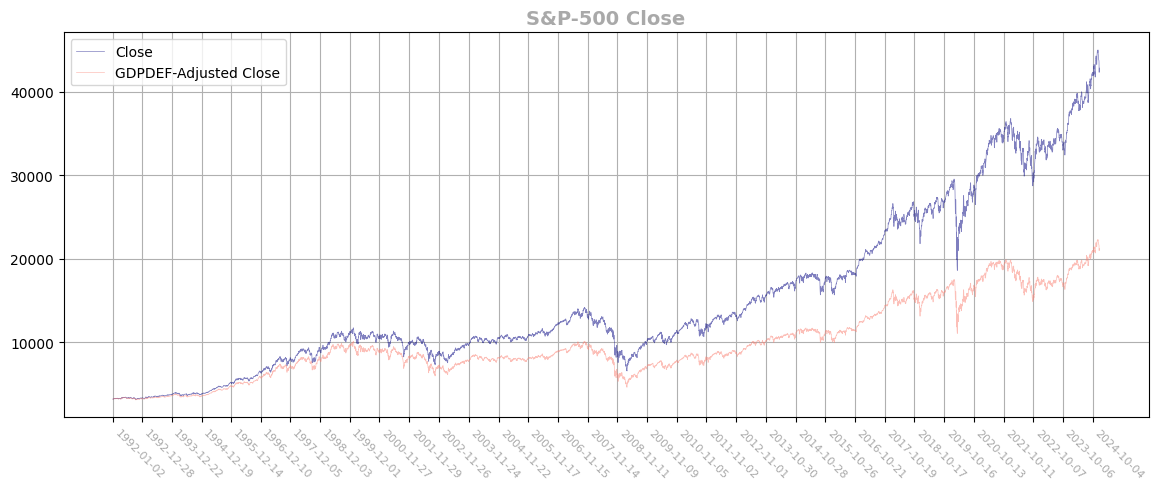

In [44]:
fig = plt.figure(figsize=(14., 5.0))
ax = fig.gca()

day = gdpdef_adj_dji_df["Day"].to_numpy()
close = gdpdef_adj_dji_df["Close"].to_numpy()
gdp_def = gdpdef_adj_dji_df["GDPDEF"].to_numpy()
gdp_def = gdp_def / gdp_def[0]
dates = gdpdef_adj_dji_df["Date"].to_numpy()

ax.set_title("S&P-500 Close", fontsize=14, fontweight="bold", color="darkgrey")
# ax.plot(day, gdp_def, lw=0.5, color="navy", alpha=0.5, label="gdp_def")
ax.plot(day, close, lw=0.5, color="navy", alpha=0.5, label="Close")
ax.plot(day, close / gdp_def, lw=0.5, color="salmon", alpha=0.5, label="GDPDEF-Adjusted Close")
ax.legend(loc="upper left")
ax.set_xticks(day[::250])
ax.set_xticklabels(dates[::250], fontsize=8, color="darkgrey", rotation=-45, ha="left", va="top")
ax.grid()
ax.set_axisbelow(True)

plt.show()


## Fit to Historical Close Prices:

In [45]:
day = gdpdef_adj_sp500_df["Day"].to_numpy()
close = gdpdef_adj_sp500_df["Close"].to_numpy()
gdp_def = gdpdef_adj_sp500_df["GDPDEF"].to_numpy()
gdp_def = gdp_def / gdp_def[0]
gdpdef_adj_close = close / gdp_def
dates = gdpdef_adj_sp500_df["Date"].to_numpy()
log_close = np.log(close)
log_gdpdef_adj_close = np.log(gdpdef_adj_close)

strt_date = "2010-01-01"
end_date = "2020-01-01"
target_date = sp500_df['Date'].iloc[-1]

strt_day_idx = sp500_df.index[sp500_df["DATETIME"] >= strt_date][0]
end_day_idx = sp500_df.index[sp500_df["DATETIME"] > end_date][0]
target_day_idx = sp500_df.index[sp500_df["DATETIME"] >= target_date][0]

print("Dates:")
print(f"\tStart Date:  {sp500_df['Date'].iloc[strt_day_idx]}")
print(f"\tEnd Date:    {sp500_df['Date'].iloc[end_day_idx]}")
print(f"\tTarget Date: {sp500_df['Date'].iloc[target_day_idx]}")

Dates:
	Start Date:  2010-01-04
	End Date:    2020-01-02
	Target Date: 2024-12-20


In [46]:
fit_results = linregress(day[strt_day_idx:end_day_idx], log_close[strt_day_idx:end_day_idx])
fit_points = fit_results[0] * day[strt_day_idx:target_day_idx] + fit_results[1]

adj_fit_results = linregress(day[strt_day_idx:end_day_idx], log_gdpdef_adj_close[strt_day_idx:end_day_idx])
adj_fit_points = adj_fit_results[0] * day[strt_day_idx:target_day_idx] + adj_fit_results[1]

print("\tSlope:       ", np.around(fit_results[0], 7))
print("\tIntercept:   ", np.around(fit_results[1], 7))
# print("\tExp Slope: ", np.around(np.exp(fit_results[0]), 7))
print("\tEst. Annual: ", np.around(np.power(1.0 + fit_results[0], 365) - 1.0, 7))
max_log_delta = np.max(log_close[strt_day_idx:target_day_idx] - fit_points)
print("Ratio of Expected to Current: ", np.around(np.exp(fit_points[-1] - log_close[target_day_idx]), 7))
print("Max Deviation:                ", np.around(np.exp(max_log_delta), 7))

print("\nProjected Price:              ", np.around(np.exp(fit_points[-1]), 3))

	Slope:        0.0002901
	Intercept:    8.5921631
	Est. Annual:  0.1116838
Ratio of Expected to Current:  0.9076285
Max Deviation:                 1.2203945

Projected Price:               5383.008


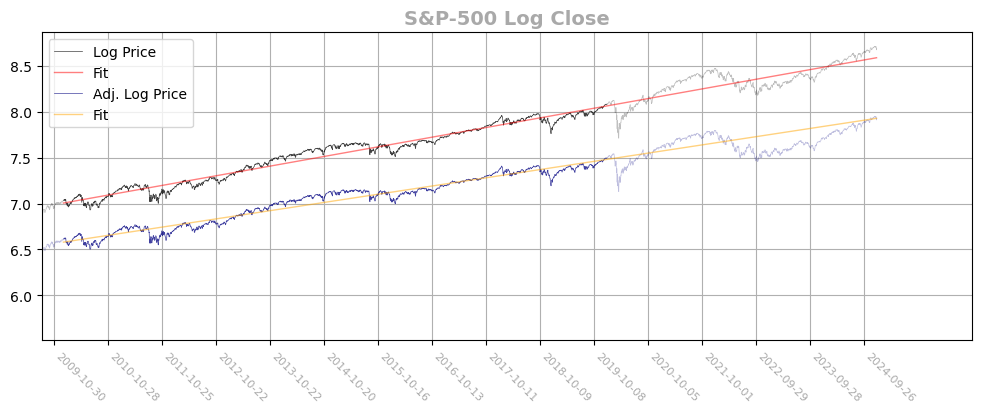

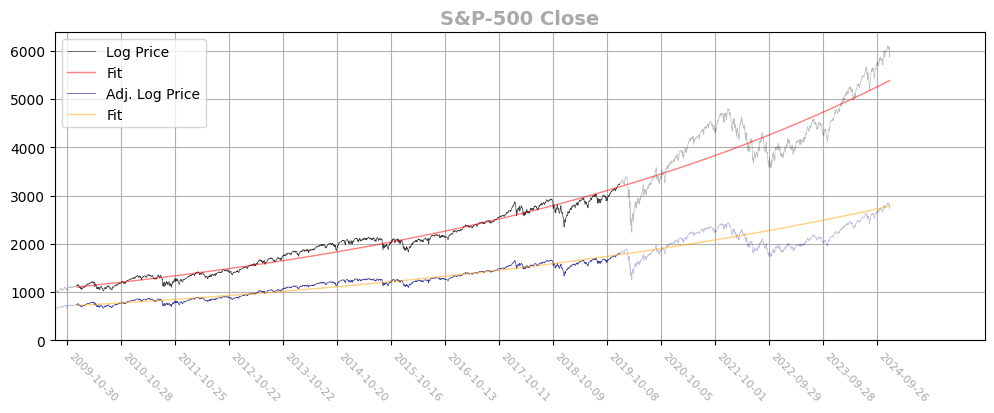

In [47]:
## Log Close Plot
fig = plt.figure(figsize=(12., 4.0))
ax = fig.gca()
#
ax.set_title("S&P-500 Log Close", fontsize=14, fontweight="bold", color="darkgrey")
ax.plot(day[strt_day_idx:end_day_idx], log_close[strt_day_idx:end_day_idx], 
        lw=0.5, color="black", alpha=0.75, label="Log Price")
ax.plot(day[:strt_day_idx], log_close[:strt_day_idx], lw=0.5, color="black", alpha=0.25, label=None)
ax.plot(day[end_day_idx:], log_close[end_day_idx:], lw=0.5, color="black", alpha=0.25, label=None)
ax.plot(day[strt_day_idx:target_day_idx], fit_points, lw=1.0, color="red", alpha=0.5, label="Fit")
#
ax.plot(day[strt_day_idx:end_day_idx], log_gdpdef_adj_close[strt_day_idx:end_day_idx], 
        lw=0.5, color="navy", alpha=0.75, label="Adj. Log Price")
ax.plot(day[:strt_day_idx], log_gdpdef_adj_close[:strt_day_idx], lw=0.5, color="navy", alpha=0.25, label=None)
ax.plot(day[end_day_idx:], log_gdpdef_adj_close[end_day_idx:], lw=0.5, color="navy", alpha=0.25, label=None)
ax.plot(day[strt_day_idx:target_day_idx], adj_fit_points, lw=1.0, color="orange", alpha=0.5, label="Fit")
#
ax.legend(loc="upper left")
ax.set_xticks(day[::250])
ax.set_xticklabels(dates[::250], fontsize=8, color="darkgrey", rotation=-45, ha="left", va="top")
ax.grid()
ax.set_axisbelow(True)
ax.set_xlim(day[strt_day_idx-100],)
#
plt.show()


## Close Plot
fig = plt.figure(figsize=(12., 4.0))
ax = fig.gca()
#
ax.set_title("S&P-500 Close", fontsize=14, fontweight="bold", color="darkgrey")
ax.plot(day[strt_day_idx:end_day_idx], close[strt_day_idx:end_day_idx], 
        lw=0.5, color="black", alpha=0.75, label="Log Price")
ax.plot(day[:strt_day_idx], close[:strt_day_idx], lw=0.5, color="black", alpha=0.25, label=None)
ax.plot(day[end_day_idx:], close[end_day_idx:], lw=0.5, color="black", alpha=0.25, label=None)
ax.plot(day[strt_day_idx:target_day_idx], np.exp(fit_points), lw=1.0, color="red", alpha=0.5, label="Fit")
#
ax.plot(day[strt_day_idx:end_day_idx], gdpdef_adj_close[strt_day_idx:end_day_idx], 
        lw=0.5, color="navy", alpha=0.75, label="Adj. Log Price")
ax.plot(day[:strt_day_idx], gdpdef_adj_close[:strt_day_idx], lw=0.5, color="navy", alpha=0.25, label=None)
ax.plot(day[end_day_idx:], gdpdef_adj_close[end_day_idx:], lw=0.5, color="navy", alpha=0.25, label=None)
ax.plot(day[strt_day_idx:target_day_idx], np.exp(adj_fit_points), lw=1.0, color="orange", alpha=0.5, label="Fit")
#
ax.legend(loc="upper left")
ax.set_xticks(day[::250])
ax.set_xticklabels(dates[::250], fontsize=8, color="darkgrey", rotation=-45, ha="left", va="top")
ax.grid()
ax.set_axisbelow(True)
ax.set_xlim(day[strt_day_idx-100],)
#
plt.show()

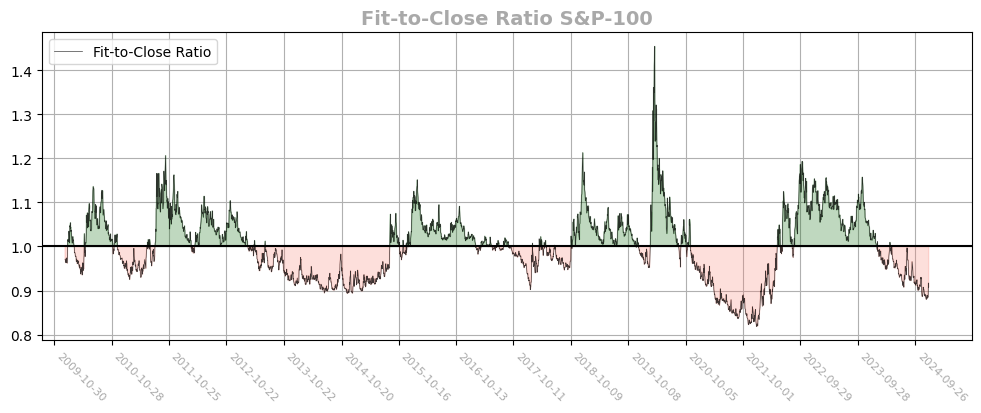

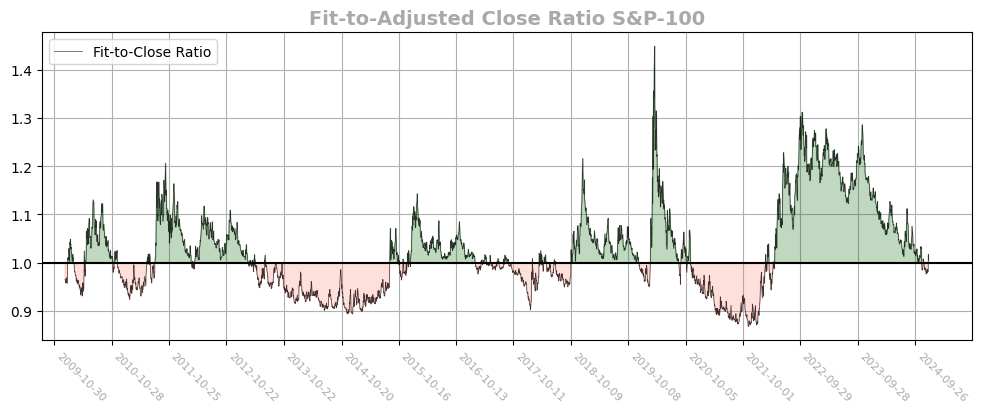

In [48]:
## Relative Close Plot
fig = plt.figure(figsize=(12., 4.0))
ax = fig.gca()
#
ax.set_title("Fit-to-Close Ratio S&P-100", fontsize=14, fontweight="bold", color="darkgrey")
x = day[strt_day_idx + 1:]
y = np.exp(fit_points) / close[strt_day_idx + 1:]
ax.plot(x, y, lw=0.5, color="black", alpha=0.75, label="Fit-to-Close Ratio")
ax.fill_between(x, 1.0, y, where=(y > 1.0), color="darkgreen", alpha=0.25)
ax.fill_between(x, 1.0, y, where=(y < 1.0), color="salmon", alpha=0.25)
ax.axhline(y = 1.0, color="black", linestyle="-", lw=1.5)
ax.legend(loc="upper left")
ax.set_xticks(day[::250])
ax.set_xticklabels(dates[::250], fontsize=8, color="darkgrey", rotation=-45, ha="left", va="top")
ax.grid()
ax.set_axisbelow(True)
ax.set_xlim(day[strt_day_idx-100],)
#
plt.show()


## GDP-Adjusted Relative Close Plot
fig = plt.figure(figsize=(12., 4.0))
ax = fig.gca()
#
ax.set_title("Fit-to-Adjusted Close Ratio S&P-100", fontsize=14, fontweight="bold", color="darkgrey")
x = day[strt_day_idx + 1:]
y = np.exp(adj_fit_points) / gdpdef_adj_close[strt_day_idx + 1:]
ax.plot(x, y, lw=0.5, color="black", alpha=0.75, label="Fit-to-Close Ratio")
ax.fill_between(x, 1.0, y, where=(y > 1.0), color="darkgreen", alpha=0.25)
ax.fill_between(x, 1.0, y, where=(y < 1.0), color="salmon", alpha=0.25)
ax.axhline(y = 1.0, color="black", linestyle="-", lw=1.5)
ax.legend(loc="upper left")
ax.set_xticks(day[::250])
ax.set_xticklabels(dates[::250], fontsize=8, color="darkgrey", rotation=-45, ha="left", va="top")
ax.grid()
ax.set_axisbelow(True)
ax.set_xlim(day[strt_day_idx-100],)
#
plt.show()

## Simple Averaging of Log Returns:

In [49]:
# close = sp500_df["Close"].to_numpy()
# day = sp500_df["Day"].to_numpy()[:-1]
# dates = sp500_df["Date"].to_numpy()[:-1]
# log_return = np.log(close[1:] / close[:-1])

# print("Log Return Mean & STD :")
# log_returns_in_range = log_return[strt_day_idx:end_day_idx]
# est_err = log_returns_in_range.std() / np.sqrt(log_returns_in_range.size)
# print(" - Mean: ", np.around(log_returns_in_range.mean(), 7), "±", np.around(est_err, 7))
# print(" - STD:  ", np.around(log_returns_in_range.std(), 7))


# fig = plt.figure(figsize=(12., 4.0))
# ax = fig.gca()
# #
# ax.set_title("Log Return", fontsize=14, fontweight="bold", color="darkgrey")
# ax.plot(day[:strt_day_idx], log_return[:strt_day_idx], lw=0.5, color="darkgrey", alpha=0.5)
# ax.plot(day[strt_day_idx:end_day_idx], log_return[strt_day_idx:end_day_idx], 
#         lw=0.5, color="steelblue", alpha=0.5)
# ax.plot(day[end_day_idx:], log_return[end_day_idx:], lw=0.5, color="darkgrey", alpha=0.5)
# ax.set_xticks(day[::250])
# ax.set_xticklabels(dates[::250], fontsize=8, color="darkgrey", rotation=-45, ha="left", va="top")
# ax.grid()
# ax.set_axisbelow(True)
# #
# plt.show()

## Cummulative Gain During Period:

In [50]:
# day = sp500_df["Day"].to_numpy()
# low = sp500_df["Low"].to_numpy()
# high = sp500_df["High"].to_numpy()
# close = sp500_df["Close"].to_numpy()
# dates = sp500_df["Date"].to_numpy()

# cumm_strt_date = "2018-01-01"
# cumm_end_date =  "2023-01-01"
# cumm_target_date = sp500_df['Date'].iloc[-1]

# cumm_strt_day_idx = sp500_df.index[sp500_df["DATETIME"] >= cumm_strt_date][0]
# cumm_end_day_idx = sp500_df.index[sp500_df["DATETIME"] > cumm_end_date][0]
# cumm_target_day_idx = sp500_df.index[sp500_df["DATETIME"] >= cumm_target_date][0]

# print("Dates:")
# print(f"\tStart Date:  {sp500_df['Date'].iloc[cumm_strt_day_idx]}")
# print(f"\tEnd Date:    {sp500_df['Date'].iloc[cumm_end_day_idx]}")
# print(f"\tTarget Date: {sp500_df['Date'].iloc[cumm_target_day_idx]}")

In [51]:
# # Compute number of shares if purchased daily with a fix amount:
# low_num_shares = np.sum(1.0 / high[cumm_strt_day_idx:cumm_end_day_idx])
# high_num_shares = np.sum(1.0 / low[cumm_strt_day_idx:cumm_end_day_idx])
# close_num_shares = np.sum(1.0 / close[cumm_strt_day_idx:cumm_end_day_idx])

# num_days = cumm_end_day_idx - cumm_strt_day_idx
# min_period_gain = low[cumm_target_day_idx] * low_num_shares / num_days
# max_period_gain = high[cumm_target_day_idx] * high_num_shares / num_days
# close_period_gain = close[cumm_target_day_idx] * close_num_shares / num_days

# print(f"\tMin Gain at Target:   {np.around(min_period_gain, 3)}")
# print(f"\tMax Gain at Target:   {np.around(max_period_gain, 3)}")
# print(f"\tClose Gain at Target: {np.around(close_period_gain, 3)}")

# annual_inflation_rate = 3.5
# inflation = np.power(1.0 + 0.01 * annual_inflation_rate, num_days / 365)
# print(f"\tInflation (at {annual_inflation_rate}% annual rate): {np.round(inflation, 2)}")